# Xopt Evaluator Basic Usage 

The `Evaluator` handles the execution of the user-provided `function` with optional `function_kwags`, asyncrhonously and parallel, with exception handling. 

In [1]:
# needed for macos
import platform
if platform.system() == "Darwin": import multiprocessing;multiprocessing.set_start_method("fork")


In [2]:
from xopt import Xopt, Evaluator, Generator, VOCS
from xopt.generators.random import RandomGenerator

from time import sleep
from numpy.random import randint

from typing import Dict

import numpy as np
np.random.seed(666) # for reproducibility

Define a custom function `f(inputs: Dict) -> outputs: Dict`. 

In [3]:
def f(inputs: Dict) -> Dict:

    sleep(randint(1, 5)*.1)  # simulate computation time
    # Make some occasional errors
    if np.any(inputs["x"] > 0.8):
        raise ValueError("x > 0.8")

    return {"f1": inputs["x"] ** 2 + inputs["y"] ** 2}

Define variables, objectives, constraints, and other settings (VOCS)

In [4]:
vocs = VOCS(variables={"x": [0, 1], "y": [0, 1]}, objectives={"f1": "MINIMIZE"})
vocs



VOCS(variables={'x': [0.0, 1.0], 'y': [0.0, 1.0]}, constraints={}, objectives={'f1': 'MINIMIZE'}, constants={}, linked_variables={})

This can be used to make some random inputs for evaluating the function. 

In [5]:
in1 = vocs.random_inputs()

f(in1)

{'f1': 0.11401572022703582}

In [6]:
# Add in occasional errors. 
try:
    f({"x": 1, "y": 0})
except Exception as ex:
    print(f"Caught error in f: {ex}")

Caught error in f: x > 0.8


In [7]:
# Create Evaluator
ev = Evaluator(function=f)

In [8]:
# Single input evaluation
ev.evaluate(in1)

{'f1': 0.11401572022703582,
 'xopt_runtime': 0.20513170800000013,
 'xopt_error': False}

In [9]:
# Dataframe evaluation
in10 = vocs.random_inputs(10)
ev.evaluate_data(in10)


,f1,xopt_runtime,xopt_error
0,0.529588,0.304726,False
1,1.154098,0.401728,False
2,0.641450,0.205126,False
3,0.619825,0.202740,False
4,0.536923,0.100665,False
5,0.342636,0.304797,False
6,0.589861,0.104920,False
7,0.556977,0.405122,False
8,0.055586,0.302209,False
9,0.785844,0.304215,False


In [10]:
# Dataframe evaluation, vectorized
ev.vectorized = True
ev.evaluate_data(in10)


,f1,xopt_runtime,xopt_error
0,0.529588,0.303243,False
1,1.154098,0.303243,False
2,0.641450,0.303243,False
3,0.619825,0.303243,False
4,0.536923,0.303243,False
5,0.342636,0.303243,False
6,0.589861,0.303243,False
7,0.556977,0.303243,False
8,0.055586,0.303243,False
9,0.785844,0.303243,False


In [11]:
futures = ev.submit_data(in10)
for ix, fut in futures.items():
    print(fut.result())

{'f1': 0.5295876188736232, 'xopt_runtime': 0.3015060829999996, 'xopt_error': False}
{'f1': 1.154097903998413, 'xopt_runtime': 0.10121483400000031, 'xopt_error': False}
{'f1': 0.641449645681512, 'xopt_runtime': 0.1041678750000008, 'xopt_error': False}
{'f1': 0.6198251611679085, 'xopt_runtime': 0.40249875000000035, 'xopt_error': False}
{'f1': 0.5369228584400957, 'xopt_runtime': 0.3051245000000007, 'xopt_error': False}
{'f1': 0.3426360721182605, 'xopt_runtime': 0.20459450000000068, 'xopt_error': False}
{'f1': 0.5898614653804399, 'xopt_runtime': 0.40509662500000054, 'xopt_error': False}
{'f1': 0.5569771979382582, 'xopt_runtime': 0.3009854170000015, 'xopt_error': False}
{'f1': 0.055585968775201305, 'xopt_runtime': 0.3031945409999999, 'xopt_error': False}
{'f1': 0.7858444543806786, 'xopt_runtime': 0.40385587499999964, 'xopt_error': False}


In [12]:
in10 = vocs.random_inputs(10)
ev.vectorized = False
ev.evaluate_data(in10)

,f1,xopt_runtime,xopt_error,xopt_error_str
0,0.994110,0.302168,False,NaN
1,0.598328,0.205121,False,NaN
2,0.590100,0.304236,False,NaN
3,NaN,0.205258,True,"Traceback (most recent call last):\n File ""/U..."
4,0.072505,0.102633,False,NaN
5,0.947951,0.101196,False,NaN
6,NaN,0.202327,True,"Traceback (most recent call last):\n File ""/U..."
7,1.231216,0.405081,False,NaN
8,NaN,0.403637,True,"Traceback (most recent call last):\n File ""/U..."
9,0.447027,0.305107,False,NaN


# Executors

In [13]:
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
MAX_WORKERS = 10

In [14]:
# Create Executor insance
executor = ProcessPoolExecutor(max_workers=MAX_WORKERS)
executor

In [15]:
# Dask (Optional)
# from dask.distributed import Client
# import logging
# client = Client( silence_logs=logging.ERROR)
# executor = client.get_executor()
# client

In [16]:
# This calls `executor.map`
ev = Evaluator(function=f, executor=executor, max_workers=MAX_WORKERS)

In [17]:
# This will run in parallel
ev.evaluate_data(in10)

,f1,xopt_runtime,xopt_error,xopt_error_str
0,0.994110,0.101535,False,NaN
1,0.598328,0.101467,False,NaN
2,0.590100,0.101023,False,NaN
3,NaN,0.101196,True,"Traceback (most recent call last):\n File ""/U..."
4,0.072505,0.100908,False,NaN
5,0.947951,0.101367,False,NaN
6,NaN,0.101721,True,"Traceback (most recent call last):\n File ""/U..."
7,1.231216,0.100834,False,NaN
8,NaN,0.100817,True,"Traceback (most recent call last):\n File ""/U..."
9,0.447027,0.101039,False,NaN


# Evaluator in the Xopt object

In [18]:
X = Xopt(generator=RandomGenerator(vocs), evaluator=Evaluator(function=f), vocs=vocs)

# Submit to the evaluator some new inputs
X.submit_data(vocs.random_inputs(4))

# Unevaluated inputs are collected in a dataframe
X._input_data

,x,y
1,0.535692,0.328119
2,0.818230,0.743436
3,0.115974,0.569198
4,0.281208,0.983546


In [19]:
# Internal futures dictionary
X._futures

{1: <Future at 0x17f4884f0 state=finished returned dict>,
 2: <Future at 0x17f4021c0 state=finished returned dict>,
 3: <Future at 0x17f43e0d0 state=finished returned dict>,
 4: <Future at 0x17f43e250 state=finished returned dict>}

In [20]:
# Collect all finished futures and updata dataframe
X.process_futures()
X.data

,x,y,f1,xopt_runtime,xopt_error,xopt_error_str
1,0.535692,0.328119,0.394628,0.200144,False,NaN
2,0.818230,0.743436,NaN,0.205316,True,"Traceback (most recent call last):\n File ""/U..."
3,0.115974,0.569198,0.337437,0.104501,False,NaN
4,0.281208,0.983546,1.046441,0.303861,False,NaN


In [21]:
# Futures are now cleared out
X._futures

{}

In [22]:
# This is the internal counter
X._ix_last

4

In [23]:
# This causes immediate evaluation
X.evaluate_data(vocs.random_inputs(4))

,f1,xopt_runtime,xopt_error,xopt_error_str
0,0.807676,0.303219,False,NaN
1,0.249059,0.204545,False,NaN
2,0.320127,0.102186,False,NaN
3,NaN,0.105073,True,"Traceback (most recent call last):\n File ""/U..."


In [24]:
# Singe generation step
X.step()
X.data

,x,y,f1,xopt_runtime,xopt_error,xopt_error_str
1,0.535692,0.328119,0.394628,0.200144,False,NaN
2,0.818230,0.743436,NaN,0.205316,True,"Traceback (most recent call last):\n File ""/U..."
3,0.115974,0.569198,0.337437,0.104501,False,NaN
4,0.281208,0.983546,1.046441,0.303861,False,NaN
0,NaN,NaN,0.807676,0.303219,False,NaN
1,NaN,NaN,0.249059,0.204545,False,NaN
2,NaN,NaN,0.320127,0.102186,False,NaN
3,NaN,NaN,NaN,0.105073,True,"Traceback (most recent call last):\n File ""/U..."
5,0.802950,0.285410,NaN,0.404729,True,"Traceback (most recent call last):\n File ""/U..."


In [25]:
# Usage with a parallel executor. 
X2 = Xopt(
    generator=RandomGenerator(vocs),
    evaluator=Evaluator(function=f, executor=executor, max_workers=MAX_WORKERS),
    vocs=vocs,
)
X2.options.asynch = True 

In [26]:
X2.step()

In [27]:
for _ in range(20):
    X2.step()

<AxesSubplot:xlabel='x', ylabel='y'>

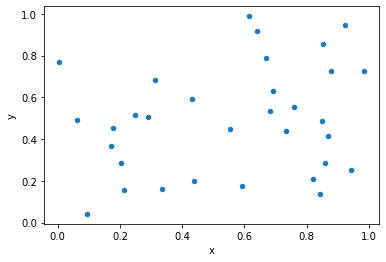

In [28]:
X2.data.plot.scatter("x", "y")

In [29]:
X2.data

,x,y,f1,xopt_runtime,xopt_error,xopt_error_str
2,0.669859,0.786717,1.067635,0.100597,False,NaN
1,0.760978,0.552324,0.884149,0.100748,False,NaN
3,0.733491,0.438846,0.730594,0.101068,False,NaN
4,0.202318,0.283422,0.121261,0.100539,False,NaN
5,0.944483,0.250679,NaN,0.101307,True,"Traceback (most recent call last):\n File ""/U..."
6,0.870193,0.413752,NaN,0.101044,True,"Traceback (most recent call last):\n File ""/U..."
7,0.177374,0.452401,0.236128,0.100603,False,NaN
8,0.639232,0.918227,1.251758,0.100893,False,NaN
9,0.430299,0.591471,0.534995,0.100256,False,NaN
10,0.169767,0.367948,0.164207,0.100505,False,NaN
